# Detecting rooftop available surface for installing PV modules in aerial images using Machine Learning

In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import torch
from torch.autograd import Variable
from torchvision.transforms.functional import normalize
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, ConcatDataset
from train.train import *
from tempfile import TemporaryFile

from process_data.data_noara_loader import *
from model.unet import *
from loss.loss import *
from process_data.data_loader import *
from hyperparameters.select_param import *
from process_data.import_test import *
from plots.plots import *

%load_ext autoreload
%autoreload 2

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#seed_torch()

# Loading the Data Set
First we load the data set that we will use for training. Each sample is an image with its mask (label). An image is represented as a 3x250x250 array with each of the 3 color chanel being 250x250 pixels. The asssociated mask is a 250x250 array, 

In [3]:
folder_path_train_image = 'data/all/train/images'
folder_path_train_masks = 'data/all/train/labels'
folder_path_test_image = 'data/all/test/images'
folder_path_test_masks = 'data/all/test/labels'
folder_path_val_image = 'data/all/val/images'
folder_path_val_masks = 'data/all/val/labels'

#load dataset
train_set = DataLoaderSegmentation(folder_path_train_image,folder_path_train_masks) # 80%
test_set = DataLoaderSegmentation(folder_path_test_image,folder_path_test_masks,augment=False)# 10%
val_set = DataLoaderSegmentation(folder_path_val_image,folder_path_val_masks,augment=False) # 10%

train_loader = DataLoader(train_set,batch_size=5, shuffle=True ,num_workers=0)
val_loader = DataLoader(val_set,batch_size=5, shuffle=True ,num_workers=0)
test_loader = DataLoader(test_set,batch_size=5, shuffle=True ,num_workers=0)

model = UNet(3,1,False).to(device)
print(len(train_set),len(test_set),len(val_set))


420 53 52


In [4]:
from torch.utils.data import TensorDataset, DataLoader
nimages = 0
mean = 0.
std = 0.
for batch, _ in train_loader:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)

# Final step
mean /= nimages
std /= nimages

print(mean)
print(std)


tensor([9.2870e-05, 2.1165e-04, 2.4778e-04])
tensor([1.0000, 0.9999, 1.0000])


# Training Loop

In [21]:
num_epochs = 50
model = UNet(3,1,False).to(device)
loss_function = torch.nn.BCEWithLogitsLoss(weight=torch.FloatTensor([4]).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trained_model = training_model(train_loader,loss_function,optimizer,model,num_epochs)

Epoch n. 0 Train Loss 2.73 Train Iou 0.4516494663474198 Time Remaining 0.2 min
----------------------------------------------
Epoch n. 25 Train Loss 0.4 Train Iou 0.922937136551231 Time Remaining 0.1 min
----------------------------------------------
Epoch n. 50 Train Loss 0.25 Train Iou 0.951789550327117 Time Remaining 0.0 min
----------------------------------------------


model = trained_model

## Export or Load trained model

In [305]:
torch.save(model.state_dict(), 'model/'+input('Name of the model file:')+".pt")

In [5]:
path = 'model/'+input('Name of the model file:')+".pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Training with adaptative learning rate

In [386]:
num_epochs = (600)
loss_function = torch.nn.BCEWithLogitsLoss(weight=torch.FloatTensor([4]).cuda())
model = UNet(3,1,False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 60, gamma=0.8, last_epoch=-1, verbose=False)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=0.01, last_epoch=-1, verbose=True)
history_train_loss, history_val_loss, history_train_iou, history_val_iou = training_model(train_loader,loss_function,optimizer,model,num_epochs,scheduler,val_loader)


Epoch n. 0 Val Loss 1.44 Val Iou 0.03333333333333333
Epoch n. 0 Train Loss 1.37 Train Iou 0.17229487607873734 Time Remaining 196.5 min
----------------------------------------------
Epoch n. 25 Val Loss 1.29 Val Iou 0.3353944053197127
Epoch n. 25 Train Loss 0.92 Train Iou 0.43487607751494856 Time Remaining 187.7 min
----------------------------------------------
Epoch n. 50 Val Loss 0.74 Val Iou 0.49099498035084876
Epoch n. 50 Train Loss 0.71 Train Iou 0.5787168623560641 Time Remaining 179.1 min
----------------------------------------------
Epoch n. 75 Val Loss 0.57 Val Iou 0.5748974245777881
Epoch n. 75 Train Loss 0.59 Train Iou 0.6467477949671442 Time Remaining 171.8 min
----------------------------------------------
Epoch n. 100 Val Loss 0.61 Val Iou 0.6209279541785162
Epoch n. 100 Train Loss 0.49 Train Iou 0.6878839950170532 Time Remaining 163.5 min
----------------------------------------------
Epoch n. 125 Val Loss 0.54 Val Iou 0.6486300490586913
Epoch n. 125 Train Loss 0.4 Trai

KeyboardInterrupt: 

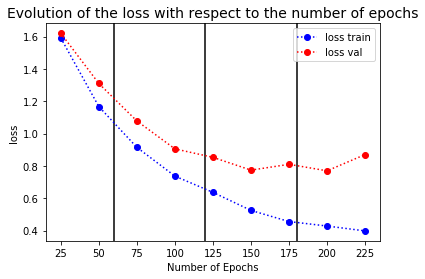

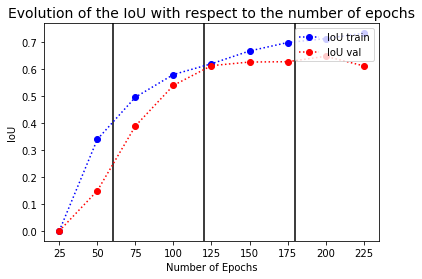

In [302]:
plot_train_val(history_train_loss,history_val_loss,period=25, al_param=60, metric='loss')
plot_train_val(history_train_iou,history_val_iou,period=25, al_param=60, metric='IoU')

In [304]:
date = input("What's the date?")
np.save('plots/history_train_iou'+date+'.npy', history_train_iou)
np.save('plots/history_train_loss'+date+'.npy', history_train_loss)
np.save('plots/history_val_iou'+date+'.npy', history_val_iou)
np.save('plots/history_val_loss'+date+'.npy', history_val_loss)

In [316]:
history_val_loss

[1.6205321875485508,
 1.3098818226294084,
 1.0779423280195757,
 0.9053408205509186,
 0.8529516323046251,
 0.7737984494729475,
 0.8097360716624693,
 0.7695533199743791,
 0.8702951994809237]

# Cross Validation

In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())
n_splits = 2
num_epochs = 10
lr = 0.01

iou_, acc_ = cross_validation(train_dataset=train_set,n_splits, loss_function, num_epochs, lr)

# Find Best Learning Rate

In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())
n_splits = 2
num_epochs = 10
lr = np.logspace(-1,-2,num=5)

best_lr, best_iou = select_hyper_param(train_dataset,n_splits,loss_function,num_epochs,lr_candidates)

# Adaptative Learning
We may do a grid search on the learning rates with cross validation to find the best learning_rate. For now the used metric is iou.

In [ ]:
lr_candidates = np.logspace(-1,-2,num=5)
num_epochs = 5
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())

best_model = UNet(3,1,False).to(device)

best_iou, history_iou = adptative_learning(train_set,val_loader,loss_function,best_model,num_epochs,lr_candidates)


In [ ]:
torch.save(best_model.state_dict(), 'model/best_model06122020.pt')

# Visualization of the model

## Display a image with its mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


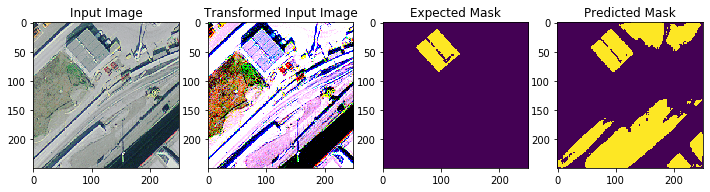

0.1357 0.739776


In [7]:
model.eval()
fig = plt.figure()
fig.set_size_inches(12, 7, forward=True)

ax1 = fig.add_subplot(1,4,1)
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(1,4,2)
ax2.title.set_text('Transformed Input Image')
ax3 = fig.add_subplot(1,4,3)
ax3.title.set_text('Expected Mask')
ax4 = fig.add_subplot(1,4,4)
ax4.title.set_text('Predicted Mask')
acc = 0
index_random_sample = int(np.random.random()*len(val_loader.dataset))
(x,y,z) = val_loader.dataset.__getitem__(index_random_sample,show_og=True)
ax1.imshow(z)

ax2.imshow(np.transpose(x.numpy(),(1,2,0)))

ax3.imshow(y)

ypred = torch.squeeze(model.predict(torch.unsqueeze(x,0).cuda())).cpu().detach().numpy()

ax4.imshow(np.around((ypred)))
np.around(iou(np.around(ypred),y.numpy()),4),accuracy(np.around(ypred),y.numpy())
acc = np.around(iou(np.around(ypred),y.numpy()),4)
plt.show()
print(acc,accuracy(np.around(ypred),y.numpy()))

## Display an unseen image

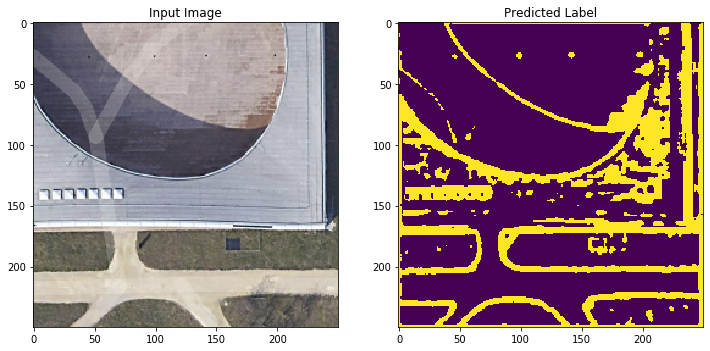

In [158]:
import_and_show(model,'test.PNG') # Note that 'test.png' should be located in the root of the folder

In [325]:
print('Train:', test_model(train_loader,model))
print('Val:', test_model(val_loader,model))
print('Test:', test_model(test_loader,model))

Train: [0.9006524568211752, 0.9863203934426229]
Val: [0.6686893573309453, 0.9536442666666667]
Test: [0.7756015653104293, 0.9708619354838709]


In [287]:
sum(p.numel() for p in model.parameters())

14788929